In [1]:
import pandas as pd
import numpy as np
import json
import warnings
import spacy
warnings.filterwarnings("ignore")
import random

import nltk
from nltk.stem import WordNetLemmatizer

import re

from spacy.tokens import DocBin

from tqdm import tqdm

In [2]:
train_data = pd.read_csv(r"train.csv")
features = pd.read_csv(r"features.csv")
patient_notes = pd.read_csv(r"C:patient_notes.csv")

In [3]:
case_8_train = train_data[train_data["case_num"] == 8]
case_8_train = case_8_train[case_8_train.annotation != '[]']
case_8_train

,id,case_num,pn_num,feature_num,annotation,location
10800,80039_800,8,80039,800,"['appetite has increased', 'eating more']","['468 490', '502 513']"
10801,80039_801,8,80039,801,['son past away at the end of June'],['171 203']
10802,80039_802,8,80039,802,['woman'],['27 32']
10804,80039_804,8,80039,804,['tossing and turning'],['124 143']
10805,80039_805,8,80039,805,['67 y.o'],['19 25']
...,...,...,...,...,...,...
12594,84366_812,8,84366,812,['anhedonia'],['674 683']
12596,84366_814,8,84366,814,['mother w/ depression'],['787 807']
12597,84366_815,8,84366,815,['waking early'],['241 253']
12598,84366_816,8,84366,816,['no suicidal'],['624 635']


In [4]:
case_8_features = features[features["case_num"] == 8]
case_8_features

,feature_num,case_num,feature_text
108,800,8,Increased-appetite
109,801,8,Son-died-3-weeks-ago
110,802,8,Female
111,803,8,Auditory-hallucination-once
112,804,8,tossing-and-turning
113,805,8,67-year
114,806,8,Difficulty-falling-asleep
115,807,8,Hallucinations-after-taking-Ambien
116,808,8,duration-3-weeks
117,809,8,Unsuccessful-napping


In [5]:
case_8_pn = patient_notes[patient_notes["case_num"] ==  8]
case_8_pn

,pn_num,case_num,pn_history
32799,80000,8,67 yo F with trouble sleeping since her son pa...
32800,80001,8,Mrs. Loraine Wicks is a 67 year old Female wit...
32801,80002,8,67 yo F with trouble sleeping\r\n- started abr...
32802,80003,8,67 year old woman with h/o HTN presenting with...
32803,80004,8,67-year-old female presenting with trouble sle...
...,...,...,...
36990,84375,8,Patient is a 67 year old female presenting wit...
36991,84376,8,Ms. Wicks is a 67 y/o f presenting with troubl...
36992,84377,8,cc: trouble sleeping \r\nPt is 67 yo woman wit...
36993,84378,8,HPI:67 YO F C/O SLEEPING PROBLEMS X 3 WEEKS AF...


In [6]:
pn_dict = {}
for idx, row in case_8_pn.iterrows():
    pn_dict[row['pn_num']] = row['pn_history']

In [7]:
new_annotation = []
for case_id in case_8_features['case_num'].unique():
    
    all_pn_id = set(case_8_pn[case_8_pn['case_num']==case_id]['pn_num'].tolist())
    
    for feature_id in case_8_features[case_8_features['case_num']==case_id]['feature_num'].unique():
        # get all the pn_num that have already been annotated
        annotated_pn = set(case_8_train[case_8_train['feature_num']==feature_id]['pn_num'].tolist())
        # get all the pn_num that have NOT been annotated
        pn_to_annotate = all_pn_id-annotated_pn
        
        # get all current annotations
        # we will use them to find more annotations
        annotations = case_8_train[case_8_train['feature_num']==feature_id]['annotation'].tolist()
        annotation_texts = set()
        for a in annotations:
            anns = eval(a)
            for at in anns:
                annotation_texts.add(at)
                
        # annotate       
        for pn_id in pn_to_annotate:
            new_annotation_pn, new_location_pn = [], []
            pn_text = pn_dict[pn_id]
            for at in annotation_texts:
                start = pn_text.find(at)
                if start>=0:
                    new_annotation_pn.append(at)
                    new_location_pn.append(f'{start} {start+len(at)}')
            if len(new_annotation_pn)>0:
                new_annotation.append((
                    f'{pn_id:04d}_{feature_id:03d}',
                    case_id,
                    pn_id,
                    feature_id,
                    new_annotation_pn,
                    new_location_pn
                ))
     #   break
    break
    # break to get sample results quickly

In [8]:
len(new_annotation)

31940

In [9]:
df=pd.DataFrame(new_annotation)

In [10]:
df.head()

,0,1,2,3,4,5
0,81920_800,8,81920,800,[eating more],[269 280]
1,81922_800,8,81922,800,[increased appeitite],[357 376]
2,81923_800,8,81923,800,"[eating more than usual, eating more]","[386 408, 386 397]"
3,81926_800,8,81926,800,[increased appetite],[533 551]
4,81931_800,8,81931,800,[increased appetite],[615 633]


In [11]:
df.columns=['id','case_num','pn_num','feature_num','annotation','location']

In [12]:
df

,id,case_num,pn_num,feature_num,annotation,location
0,81920_800,8,81920,800,[eating more],[269 280]
1,81922_800,8,81922,800,[increased appeitite],[357 376]
2,81923_800,8,81923,800,"[eating more than usual, eating more]","[386 408, 386 397]"
3,81926_800,8,81926,800,[increased appetite],[533 551]
4,81931_800,8,81931,800,[increased appetite],[615 633]
...,...,...,...,...,...,...
31935,81915_817,8,81915,817,"[4-5 hours of sleep, trouble sleeping]","[268 286, 83 99]"
31936,81916_817,8,81916,817,"[imsomnia, Sleeping problems]","[65 73, 4 21]"
31937,81917_817,8,81917,817,[difficulty sleeping],[27 46]
31938,81918_817,8,81918,817,"[difficulty sleeping, 4-5 hours of sleep]","[12 31, 178 196]"


In [13]:
df["location"] = df["location"].apply(str)
df["annotation"] = df["annotation"].apply(str)

In [14]:
df["annotation"] = df.annotation.str.replace('[','')
df["annotation"] = df.annotation.str.replace(']','')
df["location"] = df.location.str.replace('[','')
df["location"] = df.location.str.replace(']','')

df

,id,case_num,pn_num,feature_num,annotation,location
0,81920_800,8,81920,800,'eating more','269 280'
1,81922_800,8,81922,800,'increased appeitite','357 376'
2,81923_800,8,81923,800,"'eating more than usual', 'eating more'","'386 408', '386 397'"
3,81926_800,8,81926,800,'increased appetite','533 551'
4,81931_800,8,81931,800,'increased appetite','615 633'
...,...,...,...,...,...,...
31935,81915_817,8,81915,817,"'4-5 hours of sleep', 'trouble sleeping'","'268 286', '83 99'"
31936,81916_817,8,81916,817,"'imsomnia', 'Sleeping problems'","'65 73', '4 21'"
31937,81917_817,8,81917,817,'difficulty sleeping','27 46'
31938,81918_817,8,81918,817,"'difficulty sleeping', '4-5 hours of sleep'","'12 31', '178 196'"


In [15]:
df = df[['pn_num','annotation',"location","feature_num"]]
df

,pn_num,annotation,location,feature_num
0,81920,'eating more','269 280',800
1,81922,'increased appeitite','357 376',800
2,81923,"'eating more than usual', 'eating more'","'386 408', '386 397'",800
3,81926,'increased appetite','533 551',800
4,81931,'increased appetite','615 633',800
...,...,...,...,...
31935,81915,"'4-5 hours of sleep', 'trouble sleeping'","'268 286', '83 99'",817
31936,81916,"'imsomnia', 'Sleeping problems'","'65 73', '4 21'",817
31937,81917,'difficulty sleeping','27 46',817
31938,81918,"'difficulty sleeping', '4-5 hours of sleep'","'12 31', '178 196'",817


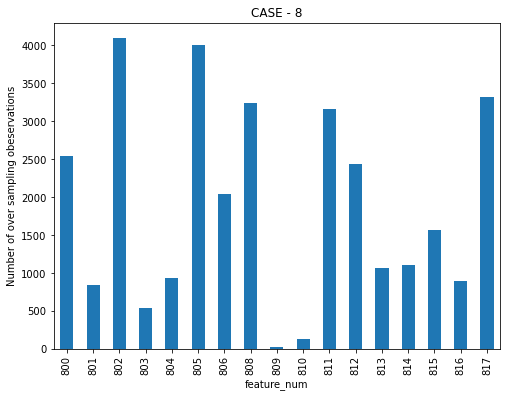

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,6])
df.groupby("feature_num").size().plot.bar()
plt.title("CASE - 8")
plt.ylabel("Number of over sampling obeservations")
plt.show()

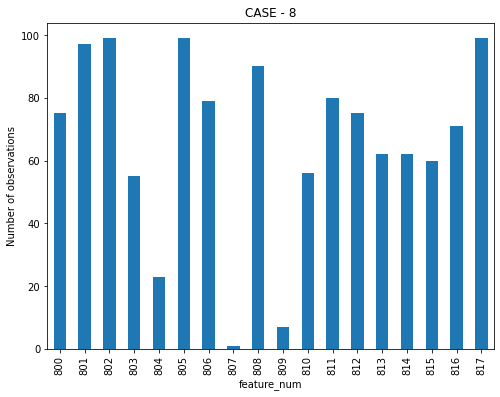

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,6])
case_8_train.groupby("feature_num").size().plot.bar()
plt.title("CASE - 8")
plt.ylabel("Number of observations")
plt.show()

#### PN History

In [18]:
case_8 = patient_notes[patient_notes.case_num== 8]

In [19]:
case_8["pn_history"] = case_8["pn_history"].apply(lambda x: re.sub(r'''[/",()\r\n]''',' ',x))

In [20]:
seperate_data = train_data.copy()

In [21]:
seperate_data = seperate_data[seperate_data.annotation != '[]']
seperate_data.head(3)

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']


In [22]:
seperate_data["annotation"] = seperate_data.annotation.str.replace('[','')
seperate_data["annotation"] = seperate_data.annotation.str.replace(']','')
seperate_data["location"] = seperate_data.location.str.replace('[','')
seperate_data["location"] = seperate_data.location.str.replace(']','')

seperate_data

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,'dad with recent heart attcak','696 724'
1,00016_001,0,16,1,"'mom with ""thyroid disease'",'668 693'
2,00016_002,0,16,2,'chest pressure','203 217'
3,00016_003,0,16,3,"'intermittent episodes', 'episode'","'70 91', '176 183'"
4,00016_004,0,16,4,'felt as if he were going to pass out','222 258'
...,...,...,...,...,...,...
14291,95333_908,9,95333,908,'Nausea','354 360'
14293,95333_910,9,95333,910,'lives with roomate','576 594'
14297,95333_914,9,95333,914,'photobia','274 282'
14298,95333_915,9,95333,915,'no sick contacts','421 437'


#### case 0 data

In [23]:
sep_case8 = seperate_data[seperate_data.case_num == 8]

In [24]:
sep_case8

,id,case_num,pn_num,feature_num,annotation,location
10800,80039_800,8,80039,800,"'appetite has increased', 'eating more'","'468 490', '502 513'"
10801,80039_801,8,80039,801,'son past away at the end of June','171 203'
10802,80039_802,8,80039,802,'woman','27 32'
10804,80039_804,8,80039,804,'tossing and turning','124 143'
10805,80039_805,8,80039,805,'67 y.o','19 25'
...,...,...,...,...,...,...
12594,84366_812,8,84366,812,'anhedonia','674 683'
12596,84366_814,8,84366,814,'mother w/ depression','787 807'
12597,84366_815,8,84366,815,'waking early','241 253'
12598,84366_816,8,84366,816,'no suicidal','624 635'


In [25]:
df1 = sep_case8[sep_case8['annotation'].str.contains(",")]
df1

,id,case_num,pn_num,feature_num,annotation,location
10800,80039_800,8,80039,800,"'appetite has increased', 'eating more'","'468 490', '502 513'"
10817,80039_817,8,80039,817,"'difficulty sleeping', 'trouble sleeping'","'42 61', '209 225'"
10819,80042_801,8,80042,801,"'At that time, her son passed away'",'168 201'
10826,80042_808,8,80042,808,"'began 3 weeks ago', '3 weeks ago'","'149 166', '321 332'"
10835,80042_817,8,80042,817,"'trouble sleeping', 'trouble staying asleep', ...","'21 37', '75 97', '132 148'"
...,...,...,...,...,...,...
12563,84255_817,8,84255,817,"'trouble sleeping', 'trouble staying asleep', ...","'24 40', '103 110;127 141', '183 213'"
12583,84366_801,8,84366,801,"'son passed away October 20th', 'loss of her s...","'145 173', '124 139;175 186'"
12584,84366_802,8,84366,802,"'Ms.', 'F'","'0 3', '27 28'"
12593,84366_811,8,84366,811,"'fatigued', 'dec energy'","'512 520', '612 622'"


In [26]:
df2 = sep_case8[sep_case8['annotation'].str.contains("',")]
df2

,id,case_num,pn_num,feature_num,annotation,location
10800,80039_800,8,80039,800,"'appetite has increased', 'eating more'","'468 490', '502 513'"
10817,80039_817,8,80039,817,"'difficulty sleeping', 'trouble sleeping'","'42 61', '209 225'"
10826,80042_808,8,80042,808,"'began 3 weeks ago', '3 weeks ago'","'149 166', '321 332'"
10835,80042_817,8,80042,817,"'trouble sleeping', 'trouble staying asleep', ...","'21 37', '75 97', '132 148'"
10847,80066_811,8,80066,811,"'feeling drained', 'tired', 'low neergy'","'315 330', '335 340', '558 568'"
...,...,...,...,...,...,...
12563,84255_817,8,84255,817,"'trouble sleeping', 'trouble staying asleep', ...","'24 40', '103 110;127 141', '183 213'"
12583,84366_801,8,84366,801,"'son passed away October 20th', 'loss of her s...","'145 173', '124 139;175 186'"
12584,84366_802,8,84366,802,"'Ms.', 'F'","'0 3', '27 28'"
12593,84366_811,8,84366,811,"'fatigued', 'dec energy'","'512 520', '612 622'"


In [27]:
set1=set(sep_case8[sep_case8['annotation'].str.contains(",")].id.unique())

In [28]:
len(set1)

162

In [29]:
set2=set(sep_case8[sep_case8['annotation'].str.contains("',")].id.unique())

In [30]:
len(set2)

147

In [31]:
set1-set2

{'80042_801',
 '80357_803',
 '80950_810',
 '81445_810',
 '81672_813',
 '81811_803',
 '81856_803',
 '81900_801',
 '81979_809',
 '81984_803',
 '81984_813',
 '81985_806',
 '82022_801',
 '82187_808',
 '83376_810'}

In [32]:
sep_case8[sep_case8.id=='80042_801']

,id,case_num,pn_num,feature_num,annotation,location
10819,80042_801,8,80042,801,"'At that time, her son passed away'",'168 201'


In [33]:
sep_case8.loc[sep_case8["annotation"] == "'At that time, her son passed away'","annotation"] = "'At that time  her son passed away'"

In [34]:
sep_case8[sep_case8.id=='80357_803'].annotation.values[0]

"'hearing distant music and talking at neighbors house, but no one was there'"

In [35]:
sep_case8.loc[sep_case8["annotation"] == "'hearing distant music and talking at neighbors house, but no one was there'","annotation"] = "'hearing distant music and talking at neighbors house  but no one was there'"

In [36]:
sep_case8[sep_case8.id=='80950_810']

,id,case_num,pn_num,feature_num,annotation,location
11224,80950_810,8,80950,810,"'AMBIEN- STARTED 5 DAYS AGO, NOT HELPED SLEEP'",'597 641'


In [37]:
sep_case8.loc[sep_case8["annotation"] == "'AMBIEN- STARTED 5 DAYS AGO, NOT HELPED SLEEP'","annotation"] = "'AMBIEN- STARTED 5 DAYS AGO  NOT HELPED SLEEP'"

In [38]:
sep_case8[sep_case8.id=='81445_810']

,id,case_num,pn_num,feature_num,annotation,location
11386,81445_810,8,81445,810,"'ambien, did not help'",'372 392'


In [39]:
sep_case8.loc[sep_case8["annotation"] == "'ambien, did not help'","annotation"] = "'ambien  did not help'"

In [40]:
sep_case8[sep_case8.id=='81672_813'].annotation.values[0]

'\'"saw her son" in the living room, although she knew he was not there\''

In [41]:
sep_case8.loc[sep_case8["annotation"] == ""'\'"saw her son" in the living room, although she knew he was not there\''"","annotation"] = ""'\'"saw her son" in the living room  although she knew he was not there\''""

In [42]:
sep_case8[sep_case8.id=='81811_803'].annotation.values[0]

"'heard sounds of party from neighbor previous night, though neightbor states there was no party'"

In [43]:
sep_case8.loc[sep_case8["annotation"] == "'heard sounds of party from neighbor previous night, though neightbor states there was no party'","annotation"] = "'heard sounds of party from neighbor previous night  though neightbor states there was no party'"

In [44]:
sep_case8[sep_case8.id=='81856_803'].annotation.values[0]

"'hearing late-night parties, which she knows are not real'"

In [45]:
sep_case8.loc[sep_case8["annotation"] == "'hearing late-night parties, which she knows are not real'","annotation"] = "'hearing late-night parties  which she knows are not real'"

In [46]:
sep_case8[sep_case8.id=='81900_801']

,id,case_num,pn_num,feature_num,annotation,location
11611,81900_801,8,81900,801,"'3WKS, STARTED AFTER SHE LOST HER SON'",'41 77'


In [47]:
sep_case8.loc[sep_case8["annotation"] == "'3WKS, STARTED AFTER SHE LOST HER SON'","annotation"] = "'3WKS  STARTED AFTER SHE LOST HER SON'"

In [48]:
sep_case8[sep_case8.id=='81979_809'].annotation.values[0]

"'tried to take naps during the day, but has been unable to fall asleep'"

In [49]:
sep_case8.loc[sep_case8["annotation"] == "'tried to take naps during the day, but has been unable to fall asleep'","annotation"] = "'tried to take naps during the day  but has been unable to fall asleep'"

In [50]:
sep_case8[sep_case8.id=='81984_803'].annotation.values[0]

'\'heard loud "party like noises" from neighbor\\\'s house 2 nights ago, but neighbor did not have a party\''

In [51]:
sep_case8.loc[sep_case8["annotation"] == ""'\'heard loud "party like noises" from neighbor\\\'s house 2 nights ago, but neighbor did not have a party\''"","annotation"] = ""'\'heard loud "party like noises" from neighbor\\\'s house 2 nights ago  but neighbor did not have a party\''""

In [52]:
sep_case8[sep_case8.id=='81984_813'].annotation.values[0]

'"saw her son at the kitchen table 4 days ago, but knows he wasn\'t there"'

In [53]:
sep_case8.loc[sep_case8["annotation"] == ""'"saw her son at the kitchen table 4 days ago, but knows he wasn\'t there"'"","annotation"] = ""'"saw her son at the kitchen table 4 days ago  but knows he wasn\'t there"'""

In [54]:
sep_case8[sep_case8.id=='81985_806']

,id,case_num,pn_num,feature_num,annotation,location
11670,81985_806,8,81985,806,"'goes to bed at 11 PM, falls asleep at midnight'",'358 404'


In [55]:
sep_case8.loc[sep_case8["annotation"] == "'goes to bed at 11 PM, falls asleep at midnight'","annotation"] = "'goes to bed at 11 PM  falls asleep at midnight'"

In [56]:
sep_case8[sep_case8.id=='82022_801']

,id,case_num,pn_num,feature_num,annotation,location
11701,82022_801,8,82022,801,"'October 13, her only son passed away'",'169 193;202 213'


In [57]:
sep_case8.loc[sep_case8["annotation"] == "'October 13, her only son passed away'","annotation"] = "'October 13  her only son passed away'"

In [58]:
sep_case8[sep_case8.id=='82187_808']

,id,case_num,pn_num,feature_num,annotation,location
11780,82187_808,8,82187,808,"'3 weeks ago, and since that time'",'81 113'


In [59]:
sep_case8.loc[sep_case8["annotation"] == "'3 weeks ago, and since that time'","annotation"] = "'3 weeks ago  and since that time'"

In [60]:
sep_case8[sep_case8.id=='83376_810'].annotation.values[0]

"'tried some medications for her sleep, but nothing helped'"

In [61]:
sep_case8.loc[sep_case8["annotation"] == "'tried some medications for her sleep, but nothing helped'","annotation"] = "'tried some medications for her sleep  but nothing helped'"

In [63]:
sep_case8.loc[sep_case8["annotation"] == "'USED TO TAKE 15 MINUTES, NOW TAKES AN HOUR', 'DIFFICULTY FALLING ASLEEP'","annotation"] = "'USED TO TAKE 15 MINUTES  NOW TAKES AN HOUR', 'DIFFICULTY FALLING ASLEEP'"

In [64]:
# 11220 'USED TO TAKE 15 MINUTES, NOW TAKES AN HOUR', 'DIFFICULTY FALLING ASLEEP' '97 139', '70 95'

In [65]:
# 12347 'difficulty sleeping', 'Baseline sleep 8hrs, but now only gets 4-5hrs sleep' '77 96', '142 193' 

In [66]:
# 12473 'difficulty sleeping', 'gets 4-5 hours per night of restless, intermittent sleep' '60 79', '101 157'

In [67]:
sep_case8.loc[sep_case8["annotation"] == "'difficulty sleeping', 'gets 4-5 hours per night of restless, intermittent sleep'","annotation"] = "'difficulty sleeping', 'gets 4-5 hours per night of restless  intermittent sleep'"

In [68]:
sep_case8.loc[sep_case8["annotation"] == "'difficulty sleeping', 'Baseline sleep 8hrs, but now only gets 4-5hrs sleep'","annotation"] = "'difficulty sleeping', 'Baseline sleep 8hrs  but now only gets 4-5hrs sleep'"

In [69]:
sep_case8 = sep_case8.drop(["id"],axis= 1)

In [70]:
sep_case8 = sep_case8.drop(["case_num"],axis= 1)

In [71]:
sep_case8 = (sep_case8.set_index(['pn_num',"feature_num"]) 
   .apply(lambda col: col.str.split(",").explode())
   .reset_index()
   .reindex(sep_case8.columns, axis=1))

In [72]:
sep_case8.head()

,pn_num,feature_num,annotation,location
0,80039,800,'appetite has increased','468 490'
1,80039,800,'eating more','502 513'
2,80039,801,'son past away at the end of June','171 203'
3,80039,802,'woman','27 32'
4,80039,804,'tossing and turning','124 143'


In [73]:
df_803 = df[df["feature_num"] == 803].sample(n = 60, random_state = 100)
df_803.shape

(60, 4)

In [74]:
df_810 = df[df["feature_num"] == 810].sample(n = 60, random_state = 100)
df_810.shape

(60, 4)

In [75]:
df_813 = df[df["feature_num"] == 813].sample(n = 60, random_state = 100)
df_813.shape

(60, 4)

In [76]:
case_8_803_over = pd.concat([sep_case8, df_803, df_810, df_813])
case_8_803_over.shape

(1559, 4)

In [77]:
df_803.head()

,pn_num,annotation,location,feature_num
7553,82525,'auditory hallucinations','285 308',803
7829,80339,'auditory hallucinations','531 554',803
7646,83203,'hearing voices','424 438',803
7531,82342,'hearing voices','226 240',803
8004,81869,'hearing voices','206 220',803


In [78]:
case_8_803_over.head()

,pn_num,feature_num,annotation,location
0,80039,800,'appetite has increased','468 490'
1,80039,800,'eating more','502 513'
2,80039,801,'son past away at the end of June','171 203'
3,80039,802,'woman','27 32'
4,80039,804,'tossing and turning','124 143'


#### Seperating start location and end location

In [79]:
case_8_803_over["start_location"] = case_8_803_over["location"].apply(lambda x: x.split()[0][1:])

In [80]:
case_8_803_over["end_location"] = case_8_803_over["location"].apply(lambda x: x.split()[-1][:-1])

#### Combinig Datasets

In [81]:
case_8_803_over = case_8_803_over.merge(patient_notes, on='pn_num', how='left')
case_8_803_over

,pn_num,feature_num,annotation,location,start_location,end_location,case_num,pn_history
0,80039,800,'appetite has increased','468 490',468,490,8,Loraine Wicks is a 67 y.o. woman here for diff...
1,80039,800,'eating more','502 513',502,513,8,Loraine Wicks is a 67 y.o. woman here for diff...
2,80039,801,'son past away at the end of June','171 203',171,203,8,Loraine Wicks is a 67 y.o. woman here for diff...
3,80039,802,'woman','27 32',27,32,8,Loraine Wicks is a 67 y.o. woman here for diff...
4,80039,804,'tossing and turning','124 143',124,143,8,Loraine Wicks is a 67 y.o. woman here for diff...
...,...,...,...,...,...,...,...,...
1554,83573,813,'visual hallucination','167 187',167,187,8,CC- trouble sleeping\r\nHPI-67yo F with troubl...
1555,82365,813,'seeing her son','576 590',576,590,8,"67F, hx of HTN and breast cancer s/p resection..."
1556,81101,813,'visual hallucination','397 417',397,417,8,67 yrs compalinig of sleeping problems started...
1557,83687,813,"'visual hallucinations', 'visual hallucination'","'464 485', '464 484'",464,484,8,HPI: 67 y-o F came with difficulty sleeping si...


In [82]:
case_8_803_over["New_annotation"] = case_8_803_over.apply(lambda x: x.pn_history[int(x.start_location):int(x.end_location)],axis=1)
case_8_803_over

,pn_num,feature_num,annotation,location,start_location,end_location,case_num,pn_history,New_annotation
0,80039,800,'appetite has increased','468 490',468,490,8,Loraine Wicks is a 67 y.o. woman here for diff...,appetite has increased
1,80039,800,'eating more','502 513',502,513,8,Loraine Wicks is a 67 y.o. woman here for diff...,eating more
2,80039,801,'son past away at the end of June','171 203',171,203,8,Loraine Wicks is a 67 y.o. woman here for diff...,son past away at the end of June
3,80039,802,'woman','27 32',27,32,8,Loraine Wicks is a 67 y.o. woman here for diff...,woman
4,80039,804,'tossing and turning','124 143',124,143,8,Loraine Wicks is a 67 y.o. woman here for diff...,tossing and turning
...,...,...,...,...,...,...,...,...,...
1554,83573,813,'visual hallucination','167 187',167,187,8,CC- trouble sleeping\r\nHPI-67yo F with troubl...,visual hallucination
1555,82365,813,'seeing her son','576 590',576,590,8,"67F, hx of HTN and breast cancer s/p resection...",seeing her son
1556,81101,813,'visual hallucination','397 417',397,417,8,67 yrs compalinig of sleeping problems started...,visual hallucination
1557,83687,813,"'visual hallucinations', 'visual hallucination'","'464 485', '464 484'",464,484,8,HPI: 67 y-o F came with difficulty sleeping si...,visual hallucination


In [83]:
case_8_803_over["New_annotation"] = case_8_803_over["New_annotation"].apply(lambda x: re.sub(r'''[/"+,()\r\n]''',' ',x))
case_8_803_over["New_annotation"] = case_8_803_over["New_annotation"].apply(lambda x: re.sub(r'''[']''','',x))
case_8_803_over["New_annotation"] = case_8_803_over["New_annotation"].apply(lambda x: x.strip())
case_8_803_over

,pn_num,feature_num,annotation,location,start_location,end_location,case_num,pn_history,New_annotation
0,80039,800,'appetite has increased','468 490',468,490,8,Loraine Wicks is a 67 y.o. woman here for diff...,appetite has increased
1,80039,800,'eating more','502 513',502,513,8,Loraine Wicks is a 67 y.o. woman here for diff...,eating more
2,80039,801,'son past away at the end of June','171 203',171,203,8,Loraine Wicks is a 67 y.o. woman here for diff...,son past away at the end of June
3,80039,802,'woman','27 32',27,32,8,Loraine Wicks is a 67 y.o. woman here for diff...,woman
4,80039,804,'tossing and turning','124 143',124,143,8,Loraine Wicks is a 67 y.o. woman here for diff...,tossing and turning
...,...,...,...,...,...,...,...,...,...
1554,83573,813,'visual hallucination','167 187',167,187,8,CC- trouble sleeping\r\nHPI-67yo F with troubl...,visual hallucination
1555,82365,813,'seeing her son','576 590',576,590,8,"67F, hx of HTN and breast cancer s/p resection...",seeing her son
1556,81101,813,'visual hallucination','397 417',397,417,8,67 yrs compalinig of sleeping problems started...,visual hallucination
1557,83687,813,"'visual hallucinations', 'visual hallucination'","'464 485', '464 484'",464,484,8,HPI: 67 y-o F came with difficulty sleeping si...,visual hallucination


#### Dropping these rows as there are spelling mistakes due to which unable to find the locations

In [84]:
case_8_803_over["New_pn_history"] = case_8_803_over["pn_history"].apply(lambda x: re.sub(r'''[/",+()\r\n]''',' ',x))
case_8_803_over["New_pn_history"] = case_8_803_over["New_pn_history"].apply(lambda x: re.sub(r'''[']''','',x))
case_8_803_over

,pn_num,feature_num,annotation,location,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history
0,80039,800,'appetite has increased','468 490',468,490,8,Loraine Wicks is a 67 y.o. woman here for diff...,appetite has increased,Loraine Wicks is a 67 y.o. woman here for diff...
1,80039,800,'eating more','502 513',502,513,8,Loraine Wicks is a 67 y.o. woman here for diff...,eating more,Loraine Wicks is a 67 y.o. woman here for diff...
2,80039,801,'son past away at the end of June','171 203',171,203,8,Loraine Wicks is a 67 y.o. woman here for diff...,son past away at the end of June,Loraine Wicks is a 67 y.o. woman here for diff...
3,80039,802,'woman','27 32',27,32,8,Loraine Wicks is a 67 y.o. woman here for diff...,woman,Loraine Wicks is a 67 y.o. woman here for diff...
4,80039,804,'tossing and turning','124 143',124,143,8,Loraine Wicks is a 67 y.o. woman here for diff...,tossing and turning,Loraine Wicks is a 67 y.o. woman here for diff...
...,...,...,...,...,...,...,...,...,...,...
1554,83573,813,'visual hallucination','167 187',167,187,8,CC- trouble sleeping\r\nHPI-67yo F with troubl...,visual hallucination,CC- trouble sleeping HPI-67yo F with trouble ...
1555,82365,813,'seeing her son','576 590',576,590,8,"67F, hx of HTN and breast cancer s/p resection...",seeing her son,67F hx of HTN and breast cancer s p resection...
1556,81101,813,'visual hallucination','397 417',397,417,8,67 yrs compalinig of sleeping problems started...,visual hallucination,67 yrs compalinig of sleeping problems started...
1557,83687,813,"'visual hallucinations', 'visual hallucination'","'464 485', '464 484'",464,484,8,HPI: 67 y-o F came with difficulty sleeping si...,visual hallucination,HPI: 67 y-o F came with difficulty sleeping si...


In [85]:
def word_lemm(sentence):
    word_list = nltk.word_tokenize(sentence)
    
    lemmaztier = WordNetLemmatizer()
    lemmatized_output = ' '.join([lemmaztier.lemmatize(w) for w in word_list])
    return(lemmatized_output)

In [86]:
case_8_803_over["New_annotation"] = case_8_803_over["New_annotation"].apply(word_lemm)
case_8_803_over["New_pn_history"] = case_8_803_over["New_pn_history"].apply(word_lemm)
case_8_803_over.head()

,pn_num,feature_num,annotation,location,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history
0,80039,800,'appetite has increased','468 490',468,490,8,Loraine Wicks is a 67 y.o. woman here for diff...,appetite ha increased,Loraine Wicks is a 67 y.o . woman here for dif...
1,80039,800,'eating more','502 513',502,513,8,Loraine Wicks is a 67 y.o. woman here for diff...,eating more,Loraine Wicks is a 67 y.o . woman here for dif...
2,80039,801,'son past away at the end of June','171 203',171,203,8,Loraine Wicks is a 67 y.o. woman here for diff...,son past away at the end of June,Loraine Wicks is a 67 y.o . woman here for dif...
3,80039,802,'woman','27 32',27,32,8,Loraine Wicks is a 67 y.o. woman here for diff...,woman,Loraine Wicks is a 67 y.o . woman here for dif...
4,80039,804,'tossing and turning','124 143',124,143,8,Loraine Wicks is a 67 y.o. woman here for diff...,tossing and turning,Loraine Wicks is a 67 y.o . woman here for dif...


In [87]:
case_8_803_over["new_location"] = case_8_803_over.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.New_pn_history),axis =1)
case_8_803_over

,pn_num,feature_num,annotation,location,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
0,80039,800,'appetite has increased','468 490',468,490,8,Loraine Wicks is a 67 y.o. woman here for diff...,appetite ha increased,Loraine Wicks is a 67 y.o . woman here for dif...,"<re.Match object; span=(460, 481), match='appe..."
1,80039,800,'eating more','502 513',502,513,8,Loraine Wicks is a 67 y.o. woman here for diff...,eating more,Loraine Wicks is a 67 y.o . woman here for dif...,"<re.Match object; span=(493, 504), match='eati..."
2,80039,801,'son past away at the end of June','171 203',171,203,8,Loraine Wicks is a 67 y.o. woman here for diff...,son past away at the end of June,Loraine Wicks is a 67 y.o . woman here for dif...,"<re.Match object; span=(170, 202), match='son ..."
3,80039,802,'woman','27 32',27,32,8,Loraine Wicks is a 67 y.o. woman here for diff...,woman,Loraine Wicks is a 67 y.o . woman here for dif...,"<re.Match object; span=(28, 33), match='woman'>"
4,80039,804,'tossing and turning','124 143',124,143,8,Loraine Wicks is a 67 y.o. woman here for diff...,tossing and turning,Loraine Wicks is a 67 y.o . woman here for dif...,"<re.Match object; span=(123, 142), match='toss..."
...,...,...,...,...,...,...,...,...,...,...,...
1554,83573,813,'visual hallucination','167 187',167,187,8,CC- trouble sleeping\r\nHPI-67yo F with troubl...,visual hallucination,CC- trouble sleeping HPI-67yo F with trouble s...,"<re.Match object; span=(167, 187), match='visu..."
1555,82365,813,'seeing her son','576 590',576,590,8,"67F, hx of HTN and breast cancer s/p resection...",seeing her son,67F hx of HTN and breast cancer s p resection ...,"<re.Match object; span=(552, 566), match='seei..."
1556,81101,813,'visual hallucination','397 417',397,417,8,67 yrs compalinig of sleeping problems started...,visual hallucination,67 yr compalinig of sleeping problem started 3...,"<re.Match object; span=(395, 415), match='visu..."
1557,83687,813,"'visual hallucinations', 'visual hallucination'","'464 485', '464 484'",464,484,8,HPI: 67 y-o F came with difficulty sleeping si...,visual hallucination,HPI : 67 y-o F came with difficulty sleeping s...,"<re.Match object; span=(455, 475), match='visu..."


In [88]:
i = 0
for location in case_8_803_over["new_location"]:
    if location == None:
        i+= 1
        
print(i)

31


In [89]:
drop_index = []
for  index,row in case_8_803_over.iterrows():
    if row["new_location"] == None:
        drop_index.append(index)
        
print(drop_index),len(drop_index)

[77, 353, 372, 373, 488, 495, 509, 520, 521, 522, 576, 578, 590, 621, 684, 692, 818, 885, 887, 890, 994, 1037, 1122, 1137, 1149, 1155, 1274, 1349, 1350, 1362, 1477]


(None, 31)

In [90]:
case_8_803_over = case_8_803_over.drop(drop_index,axis = 0)

In [91]:
case_8_803_over["start_location"] = case_8_803_over.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.New_pn_history).start(),axis =1)
case_8_803_over["end_location"] = case_8_803_over.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.New_pn_history).end(),axis =1)
case_8_803_over

,pn_num,feature_num,annotation,location,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
0,80039,800,'appetite has increased','468 490',460,481,8,Loraine Wicks is a 67 y.o. woman here for diff...,appetite ha increased,Loraine Wicks is a 67 y.o . woman here for dif...,"<re.Match object; span=(460, 481), match='appe..."
1,80039,800,'eating more','502 513',493,504,8,Loraine Wicks is a 67 y.o. woman here for diff...,eating more,Loraine Wicks is a 67 y.o . woman here for dif...,"<re.Match object; span=(493, 504), match='eati..."
2,80039,801,'son past away at the end of June','171 203',170,202,8,Loraine Wicks is a 67 y.o. woman here for diff...,son past away at the end of June,Loraine Wicks is a 67 y.o . woman here for dif...,"<re.Match object; span=(170, 202), match='son ..."
3,80039,802,'woman','27 32',28,33,8,Loraine Wicks is a 67 y.o. woman here for diff...,woman,Loraine Wicks is a 67 y.o . woman here for dif...,"<re.Match object; span=(28, 33), match='woman'>"
4,80039,804,'tossing and turning','124 143',123,142,8,Loraine Wicks is a 67 y.o. woman here for diff...,tossing and turning,Loraine Wicks is a 67 y.o . woman here for dif...,"<re.Match object; span=(123, 142), match='toss..."
...,...,...,...,...,...,...,...,...,...,...,...
1554,83573,813,'visual hallucination','167 187',167,187,8,CC- trouble sleeping\r\nHPI-67yo F with troubl...,visual hallucination,CC- trouble sleeping HPI-67yo F with trouble s...,"<re.Match object; span=(167, 187), match='visu..."
1555,82365,813,'seeing her son','576 590',552,566,8,"67F, hx of HTN and breast cancer s/p resection...",seeing her son,67F hx of HTN and breast cancer s p resection ...,"<re.Match object; span=(552, 566), match='seei..."
1556,81101,813,'visual hallucination','397 417',395,415,8,67 yrs compalinig of sleeping problems started...,visual hallucination,67 yr compalinig of sleeping problem started 3...,"<re.Match object; span=(395, 415), match='visu..."
1557,83687,813,"'visual hallucinations', 'visual hallucination'","'464 485', '464 484'",455,475,8,HPI: 67 y-o F came with difficulty sleeping si...,visual hallucination,HPI : 67 y-o F came with difficulty sleeping s...,"<re.Match object; span=(455, 475), match='visu..."


In [92]:
case_8_803_over

,pn_num,feature_num,annotation,location,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
0,80039,800,'appetite has increased','468 490',460,481,8,Loraine Wicks is a 67 y.o. woman here for diff...,appetite ha increased,Loraine Wicks is a 67 y.o . woman here for dif...,"<re.Match object; span=(460, 481), match='appe..."
1,80039,800,'eating more','502 513',493,504,8,Loraine Wicks is a 67 y.o. woman here for diff...,eating more,Loraine Wicks is a 67 y.o . woman here for dif...,"<re.Match object; span=(493, 504), match='eati..."
2,80039,801,'son past away at the end of June','171 203',170,202,8,Loraine Wicks is a 67 y.o. woman here for diff...,son past away at the end of June,Loraine Wicks is a 67 y.o . woman here for dif...,"<re.Match object; span=(170, 202), match='son ..."
3,80039,802,'woman','27 32',28,33,8,Loraine Wicks is a 67 y.o. woman here for diff...,woman,Loraine Wicks is a 67 y.o . woman here for dif...,"<re.Match object; span=(28, 33), match='woman'>"
4,80039,804,'tossing and turning','124 143',123,142,8,Loraine Wicks is a 67 y.o. woman here for diff...,tossing and turning,Loraine Wicks is a 67 y.o . woman here for dif...,"<re.Match object; span=(123, 142), match='toss..."
...,...,...,...,...,...,...,...,...,...,...,...
1554,83573,813,'visual hallucination','167 187',167,187,8,CC- trouble sleeping\r\nHPI-67yo F with troubl...,visual hallucination,CC- trouble sleeping HPI-67yo F with trouble s...,"<re.Match object; span=(167, 187), match='visu..."
1555,82365,813,'seeing her son','576 590',552,566,8,"67F, hx of HTN and breast cancer s/p resection...",seeing her son,67F hx of HTN and breast cancer s p resection ...,"<re.Match object; span=(552, 566), match='seei..."
1556,81101,813,'visual hallucination','397 417',395,415,8,67 yrs compalinig of sleeping problems started...,visual hallucination,67 yr compalinig of sleeping problem started 3...,"<re.Match object; span=(395, 415), match='visu..."
1557,83687,813,"'visual hallucinations', 'visual hallucination'","'464 485', '464 484'",455,475,8,HPI: 67 y-o F came with difficulty sleeping si...,visual hallucination,HPI : 67 y-o F came with difficulty sleeping s...,"<re.Match object; span=(455, 475), match='visu..."


In [93]:
sep_combined_case8=case_8_803_over.copy()

In [94]:
# sep_combined_case8  = sep_combined_case8.drop(['annotation', 'start_location','end_location'],axis = 1)

In [95]:
# sep_combined_case8[sep_combined_case8.feature_num == 800].shape

#### Feature 800

In [96]:
sep_combined_case8_800 = sep_combined_case8[sep_combined_case8.feature_num == 800]

In [97]:
sep_combined_case8_800 = sep_combined_case8_800.drop(index=1257)

In [98]:
pn_Num_list = list(sep_combined_case8_800.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case8_800[sep_combined_case8_800.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case8_800[sep_combined_case8_800.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
            

In [100]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_800.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_800.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]
print(len(train), len(validation))

60 15


In [103]:
from spacy.tokens import DocBin
import spacy
from tqdm import tqdm
import random


In [104]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_800.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 493.36it/s]


In [105]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_800.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 646.31it/s]


In [106]:
!python -m spacy init fill-config ./base_config_800.cfg ./config_800.cfg

[+] Auto-filled config with all values
[+] Saved config
config_800.cfg
You can now add your data and train your pipeline:
python -m spacy train config_800.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-12 18:06:41.425428: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 18:06:41.425504: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [107]:
!python -m spacy train config_800.cfg --output ./output_800

[i] Saving to output directory: output_800
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     56.67    0.00    0.00    0.00    0.00
  3     200         26.64   1122.14   56.25   52.94   60.00    0.56
  6     400         24.32     47.95   75.00   70.59   80.00    0.75
 10     600         32.54     24.19   81.25   76.47   86.67    0.81
 13     800          6.43      9.13   81.25   76.47   86.67    0.81
 16    1000          0.00      0.01   78.79   72.22   86.67    0.79
 20    1200          0.00      0.00   72.73   66.67   80.00    0.73
 23    1400          0.00      0.00   72.73   66.67   80.00    0.73
 26    1600      

2022-05-12 18:06:48.569094: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 18:06:48.569168: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-12 18:06:53,440] [INFO] Set up nlp object from config
[2022-05-12 18:06:53,448] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-12 18:06:53,452] [INFO] Created vocabulary
[2022-05-12 18:06:53,455] [INFO] Finished initializing nlp object
[2022-05-12 18:06:54,091] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


#### Feature 801

In [108]:
sep_combined_case8_801 = sep_combined_case8[sep_combined_case8.feature_num == 801]

In [109]:
sep_combined_case8_801 = sep_combined_case8_801.drop(index=386)

In [110]:
sep_combined_case8_801 = sep_combined_case8_801.drop(index=1360)

In [111]:
sep_combined_case8_801

,pn_num,feature_num,annotation,location,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
2,80039,801,'son past away at the end of June','171 203',170,202,8,Loraine Wicks is a 67 y.o. woman here for diff...,son past away at the end of June,Loraine Wicks is a 67 y.o . woman here for dif...,"<re.Match object; span=(170, 202), match='son ..."
16,80042,801,'At that time her son passed away','168 201',166,198,8,67yo F presents with trouble sleeping. She rep...,At that time her son passed away,67yo F present with trouble sleeping . She rep...,"<re.Match object; span=(166, 198), match='At t..."
30,80066,801,'x 3 weeks since the death of her son','41 77',41,76,8,Pt is a 67 yo F presenting with insomnia x 3 w...,x 3 week since the death of her son,Pt is a 67 yo F presenting with insomnia x 3 w...,"<re.Match object; span=(41, 76), match='x 3 we..."
49,80098,801,'3 Wks ago death of her son','96 105;120 136',97,137,8,Mrs Loraine Wicks a 67 Y old F pt presenting t...,3 Wks ago following the death of her son,Mrs Loraine Wicks a 67 Y old F pt presenting t...,"<re.Match object; span=(97, 137), match='3 Wks..."
61,80245,801,'3 weeks ago son passed away','131 142;153 168',131,167,8,Pt is a 67 year old female with PMH of high bl...,3 week ago after her son passed away,Pt is a 67 year old female with PMH of high bl...,"<re.Match object; span=(131, 167), match='3 we..."
...,...,...,...,...,...,...,...,...,...,...,...
1307,84191,801,'son unfortunately passed away 3 weeks ago','364 405',358,398,8,"Identity: Loraine Wicks, a 67-year-old female\...",son unfortunately passed away 3 week ago,Identity : Loraine Wicks a 67-year-old female ...,"<re.Match object; span=(358, 398), match='son ..."
1320,84231,801,'son dying 3 weeks ago','153 174',151,171,8,Loraine Wicks is a 67 yo F with a history of H...,son dying 3 week ago,Loraine Wicks is a 67 yo F with a history of H...,"<re.Match object; span=(151, 171), match='son ..."
1330,84255,801,'son died 3 weeks','220 236',213,228,8,"HPI: 67 yo F, G1P1, c/o trouble sleeping for t...",son died 3 week,HPI : 67 yo F G1P1 c o trouble sleeping for th...,"<re.Match object; span=(213, 228), match='son ..."
1348,84273,801,'son passing away 3 weeks ago','344 372',331,358,8,"67F w/ PMH of breast CA in remission, presenti...",son passing away 3 week ago,67F w PMH of breast CA in remission presenting...,"<re.Match object; span=(331, 358), match='son ..."


In [112]:
sep_combined_case8_801.head()

,pn_num,feature_num,annotation,location,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
2,80039,801,'son past away at the end of June','171 203',170,202,8,Loraine Wicks is a 67 y.o. woman here for diff...,son past away at the end of June,Loraine Wicks is a 67 y.o . woman here for dif...,"<re.Match object; span=(170, 202), match='son ..."
16,80042,801,'At that time her son passed away','168 201',166,198,8,67yo F presents with trouble sleeping. She rep...,At that time her son passed away,67yo F present with trouble sleeping . She rep...,"<re.Match object; span=(166, 198), match='At t..."
30,80066,801,'x 3 weeks since the death of her son','41 77',41,76,8,Pt is a 67 yo F presenting with insomnia x 3 w...,x 3 week since the death of her son,Pt is a 67 yo F presenting with insomnia x 3 w...,"<re.Match object; span=(41, 76), match='x 3 we..."
49,80098,801,'3 Wks ago death of her son','96 105;120 136',97,137,8,Mrs Loraine Wicks a 67 Y old F pt presenting t...,3 Wks ago following the death of her son,Mrs Loraine Wicks a 67 Y old F pt presenting t...,"<re.Match object; span=(97, 137), match='3 Wks..."
61,80245,801,'3 weeks ago son passed away','131 142;153 168',131,167,8,Pt is a 67 year old female with PMH of high bl...,3 week ago after her son passed away,Pt is a 67 year old female with PMH of high bl...,"<re.Match object; span=(131, 167), match='3 we..."


In [113]:
pn_Num_list = list(sep_combined_case8_801.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case8_801[sep_combined_case8_801.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case8_801[sep_combined_case8_801.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
            

In [114]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_801.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_801.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [115]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_801.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 585.62it/s]


In [116]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_801.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 665.64it/s]


In [117]:
!python -m spacy init fill-config ./base_config_801.cfg ./config_801.cfg

2022-05-12 18:10:52.916316: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 18:10:52.916356: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[+] Auto-filled config with all values
[+] Saved config
config_801.cfg
You can now add your data and train your pipeline:
python -m spacy train config_801.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [118]:
!python -m spacy train config_801.cfg --output ./output_801

[i] Saving to output directory: output_801
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     56.67    0.00    0.00    0.00    0.00
  2     200       2615.85   2494.60   16.00   40.00   10.00    0.16
  5     400         83.10    295.17   34.15   33.33   35.00    0.34
  7     600        368.87    189.84   24.49   20.69   30.00    0.24
 10     800        140.18    124.25   27.78   31.25   25.00    0.28
 12    1000        117.63    104.68   31.11   28.00   35.00    0.31
 15    1200        515.06     83.47   26.67   24.00   30.00    0.27
 18    1400         47.37     35.64   29.27   28.57   30.00    0.29
 20    1600      

2022-05-12 18:10:58.972003: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 18:10:58.972086: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-12 18:11:02,990] [INFO] Set up nlp object from config
[2022-05-12 18:11:02,998] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-12 18:11:03,002] [INFO] Created vocabulary
[2022-05-12 18:11:03,004] [INFO] Finished initializing nlp object
[2022-05-12 18:11:03,461] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


#### Feature 802

In [119]:
sep_combined_case8_802 = sep_combined_case8[sep_combined_case8.feature_num == 802]

In [120]:
pn_Num_list = list(sep_combined_case8_802.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case8_802[sep_combined_case8_802.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case8_802[sep_combined_case8_802.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
            

In [121]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_802.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_802.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [122]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_802.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 513.57it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


In [123]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_802.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 742.06it/s]

Skipping entity


In [124]:
!python -m spacy init fill-config ./base_config_802.cfg ./config_802.cfg

[+] Auto-filled config with all values
[+] Saved config
config_802.cfg
You can now add your data and train your pipeline:
python -m spacy train config_802.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-12 18:19:17.606215: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 18:19:17.606260: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [205]:
!python -m spacy train config_802.cfg --output ./output_802

[i] Saving to output directory: output_802
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     51.33    0.00    0.00    0.00    0.00
  2     200          6.64   1027.48   95.00   90.48  100.00    0.95
  5     400          1.64      1.78  100.00  100.00  100.00    1.00
  7     600          0.00      0.00  100.00  100.00  100.00    1.00
 10     800          0.00      0.00  100.00  100.00  100.00    1.00
 13    1000          0.00      0.00  100.00  100.00  100.00    1.00
 15    1200          0.00      0.00  100.00  100.00  100.00    1.00
 18    1400          0.00      0.00  100.00  100.00  100.00    1.00
 21    1600      

2022-05-12 19:08:53.250367: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 19:08:53.250423: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-12 19:08:57,765] [INFO] Set up nlp object from config
[2022-05-12 19:08:57,772] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-12 19:08:57,776] [INFO] Created vocabulary
[2022-05-12 19:08:57,776] [INFO] Finished initializing nlp object
[2022-05-12 19:08:58,207] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


#### Feature 803

In [207]:
sep_combined_case8_803 = sep_combined_case8[sep_combined_case8.feature_num == 803]

In [209]:
pn_Num_list = list(sep_combined_case8_803.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case8_803[sep_combined_case8_803.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case8_803[sep_combined_case8_803.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
            

In [211]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_803.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_803.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [213]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_803.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 422.45it/s]


In [215]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_803.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 540.13it/s]


In [217]:
!python -m spacy init fill-config ./base_config_803.cfg ./config_803.cfg

[+] Auto-filled config with all values
[+] Saved config
config_803.cfg
You can now add your data and train your pipeline:
python -m spacy train config_803.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-12 19:20:10.254452: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 19:20:10.254497: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [219]:
!python -m spacy train config_803.cfg --output ./output_803

[i] Saving to output directory: output_803
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     63.33    1.78    0.92   30.43    0.02
  2     200       1670.96   1627.22   80.85   79.17   82.61    0.81
  4     400        361.90    232.66   42.55   41.67   43.48    0.43
  6     600        163.08    163.71   89.36   87.50   91.30    0.89
  8     800         83.96    105.85   88.00   81.48   95.65    0.88
 10    1000         58.85     52.54   95.83   92.00  100.00    0.96
 13    1200        165.41     53.19   87.50   84.00   91.30    0.87
 15    1400         61.34     34.18   84.00   77.78   91.30    0.84
 17    1600      

2022-05-12 19:20:16.374924: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 19:20:16.374963: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-12 19:20:19,966] [INFO] Set up nlp object from config
[2022-05-12 19:20:19,973] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-12 19:20:19,976] [INFO] Created vocabulary
[2022-05-12 19:20:19,977] [INFO] Finished initializing nlp object
[2022-05-12 19:20:20,410] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


#### Feature 804

In [221]:
sep_combined_case8_804 = sep_combined_case8[sep_combined_case8.feature_num == 804]

In [223]:
pn_Num_list = list(sep_combined_case8_804.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case8_804[sep_combined_case8_804.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case8_804[sep_combined_case8_804.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
            

In [225]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_804.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_804.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [227]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_804.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 569.47it/s]


In [229]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_804.spacy")

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 606.53it/s]


In [231]:
!python -m spacy init fill-config ./base_config_804.cfg ./config_804.cfg

[+] Auto-filled config with all values
[+] Saved config
config_804.cfg
You can now add your data and train your pipeline:
python -m spacy train config_804.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-12 19:33:02.599197: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 19:33:02.599237: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [233]:
!python -m spacy train config_804.cfg --output ./output_804

[i] Saving to output directory: output_804
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     63.50    0.00    0.00    0.00    0.00
 11     200       3215.92   2489.07  100.00  100.00  100.00    1.00
 22     400          0.00      0.00  100.00  100.00  100.00    1.00
 33     600          0.00      0.00  100.00  100.00  100.00    1.00
 44     800          0.00      0.00  100.00  100.00  100.00    1.00
 55    1000          0.00      0.00  100.00  100.00  100.00    1.00
 66    1200          0.00      0.00  100.00  100.00  100.00    1.00
 77    1400          0.00      0.00  100.00  100.00  100.00    1.00
 88    1600      

2022-05-12 19:33:07.712498: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 19:33:07.712535: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-12 19:33:11,319] [INFO] Set up nlp object from config
[2022-05-12 19:33:11,327] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-12 19:33:11,331] [INFO] Created vocabulary
[2022-05-12 19:33:11,331] [INFO] Finished initializing nlp object
[2022-05-12 19:33:11,635] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


#### Feature 805

In [235]:
sep_combined_case8_805 = sep_combined_case8[sep_combined_case8.feature_num == 805]

In [237]:
pn_Num_list = list(sep_combined_case8_805.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case8_805[sep_combined_case8_805.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case8_805[sep_combined_case8_805.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
            

In [239]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_805.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_805.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [241]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_805.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 609.27it/s]


In [243]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_805.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 871.33it/s]


In [245]:
!python -m spacy init fill-config ./base_config_805.cfg ./config_805.cfg

[+] Auto-filled config with all values
[+] Saved config
config_805.cfg
You can now add your data and train your pipeline:
python -m spacy train config_805.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-12 19:41:02.952754: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 19:41:02.952793: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [247]:
!python -m spacy train config_805.cfg --output ./output_805

[i] Saving to output directory: output_805
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     58.00    2.25    1.18   26.32    0.02
  2     200       1682.17   2177.70  100.00  100.00  100.00    1.00
  5     400          1.18      2.53   97.30  100.00   94.74    0.97
  8     600          0.00      0.00   97.30  100.00   94.74    0.97
 10     800          0.00      0.00   97.30  100.00   94.74    0.97
 13    1000          0.00      0.00   97.30  100.00   94.74    0.97
 16    1200          0.00      0.00   97.30  100.00   94.74    0.97
 18    1400          0.00      0.00   97.30  100.00   94.74    0.97
 21    1600      

2022-05-12 19:41:08.232127: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 19:41:08.232167: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-12 19:41:12,453] [INFO] Set up nlp object from config
[2022-05-12 19:41:12,461] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-12 19:41:12,465] [INFO] Created vocabulary
[2022-05-12 19:41:12,466] [INFO] Finished initializing nlp object
[2022-05-12 19:41:12,904] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


#### Feature 806

In [249]:
sep_combined_case8_806 = sep_combined_case8[sep_combined_case8.feature_num == 806]

In [251]:
pn_Num_list = list(sep_combined_case8_806.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case8_806[sep_combined_case8_806.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case8_806[sep_combined_case8_806.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
            

In [253]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_806.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_806.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [255]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_806.spacy")

100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 1301.31it/s]


In [257]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_806.spacy")

100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1126.10it/s]


In [259]:
!python -m spacy init fill-config ./base_config_806.cfg ./config_806.cfg

[+] Auto-filled config with all values
[+] Saved config
config_806.cfg
You can now add your data and train your pipeline:
python -m spacy train config_806.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-12 19:44:12.967198: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 19:44:12.967236: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [261]:
!python -m spacy train config_806.cfg --output ./output_806

[i] Saving to output directory: output_806
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     68.50    0.00    0.00    0.00    0.00
  3     200       2623.80   2249.13   93.33  100.00   87.50    0.93
  6     400         40.88     77.47   90.32   93.33   87.50    0.90
  9     600      15032.34    179.44   86.67   92.86   81.25    0.87
 12     800         17.71     25.14   85.71  100.00   75.00    0.86
 16    1000          6.88      6.36   90.32   93.33   87.50    0.90
 19    1200         16.39     14.71   90.32   93.33   87.50    0.90
 22    1400        184.81     22.96   86.67   92.86   81.25    0.87
 25    1600      

2022-05-12 19:47:23.067663: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 19:47:23.067701: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-12 19:47:26,690] [INFO] Set up nlp object from config
[2022-05-12 19:47:26,698] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-12 19:47:26,702] [INFO] Created vocabulary
[2022-05-12 19:47:26,703] [INFO] Finished initializing nlp object
[2022-05-12 19:47:27,092] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


#### Feature 807

In [263]:
sep_combined_case8_807 = sep_combined_case8[sep_combined_case8.feature_num == 807]
sep_combined_case8_807.shape

(1, 11)

In [265]:
sep_combined_case8_807

,pn_num,feature_num,annotation,location,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
874,82622,807,'started taking Ambien from a friend recently ...,'446 526',434,513,8,HOI: 67 y/o F c/o difficulty falling asleep an...,started taking Ambien from a friend recently a...,HOI : 67 y o F c o difficulty falling asleep a...,"<re.Match object; span=(434, 513), match='star..."


In [267]:
## Only 1 one observation

In [269]:
pn_Num_list = list(sep_combined_case8_807.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case8_807[sep_combined_case8_807.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case8_807[sep_combined_case8_807.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
            

In [271]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_807.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_807.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [273]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_807.spacy")

0it [00:00, ?it/s]


In [275]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_807.spacy")

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 230.86it/s]


In [277]:
!python -m spacy init fill-config ./base_config_807.cfg ./config_807.cfg

[+] Auto-filled config with all values
[+] Saved config
config_807.cfg
You can now add your data and train your pipeline:
python -m spacy train config_807.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-12 19:50:08.219273: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 19:50:08.219311: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [279]:
!python -m spacy train config_807.cfg --output ./output_807

[i] Saving to output directory: output_807
[i] Using CPU

=========================== Initializing pipeline ===========================


2022-05-12 19:50:13.232744: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 19:50:13.232782: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-12 19:50:16,650] [INFO] Set up nlp object from config
[2022-05-12 19:50:16,658] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-12 19:50:16,661] [INFO] Created vocabulary
[2022-05-12 19:50:16,662] [INFO] Finished initializing nlp object
Traceback (most recent call last):
  File "C:\Users\hp\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\hp\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\hp\anaconda3\lib\site-packages\spacy\__main__.py", line 4, in <module>
    setup_cli()
  File "C:\Users\hp\anaconda3\lib\site-packages\spacy\cli\_ut

#### Feature 808

In [281]:
sep_combined_case8_808 = sep_combined_case8[sep_combined_case8.feature_num == 808]

In [283]:
sep_combined_case8_808 = sep_combined_case8_808.drop(index=21)

In [285]:
pn_Num_list = list(sep_combined_case8_808.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case8_808[sep_combined_case8_808.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case8_808[sep_combined_case8_808.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
            

In [287]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_808.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_808.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [289]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_808.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 822.74it/s]


In [291]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_808.spacy")

100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1032.25it/s]


In [293]:
!python -m spacy init fill-config ./base_config_808.cfg ./config_808.cfg

[+] Auto-filled config with all values
[+] Saved config
config_808.cfg
You can now add your data and train your pipeline:
python -m spacy train config_808.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-12 19:50:18.700325: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 19:50:18.700360: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [295]:
!python -m spacy train config_808.cfg --output ./output_808

[i] Saving to output directory: output_808
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     59.50    0.35    0.18    5.56    0.00
  2     200       1531.33   2301.28   63.41   56.52   72.22    0.63
  5     400         54.75    213.19   64.71   68.75   61.11    0.65
  8     600         69.12    129.75   73.68   70.00   77.78    0.74
 11     800        350.80     93.53   64.71   68.75   61.11    0.65
 14    1000         70.81     55.60   65.00   59.09   72.22    0.65
 16    1200        101.56     62.48   58.54   52.17   66.67    0.59
 19    1400        214.38     54.57   64.71   68.75   61.11    0.65
 22    1600      

2022-05-12 19:50:23.724743: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 19:50:23.724781: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-12 19:50:27,193] [INFO] Set up nlp object from config
[2022-05-12 19:50:27,201] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-12 19:50:27,204] [INFO] Created vocabulary
[2022-05-12 19:50:27,205] [INFO] Finished initializing nlp object
[2022-05-12 19:50:27,580] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


#### Feature 809

In [297]:
sep_combined_case8_809 = sep_combined_case8[sep_combined_case8.feature_num == 809]

In [299]:
pn_Num_list = list(sep_combined_case8_809.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case8_809[sep_combined_case8_809.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case8_809[sep_combined_case8_809.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
            

In [301]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_809.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_809.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [302]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_809.spacy")

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 209.99it/s]


In [303]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_809.spacy")

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 290.50it/s]


In [304]:
!python -m spacy init fill-config ./base_config_809.cfg ./config_809.cfg

[+] Auto-filled config with all values
[+] Saved config
config_809.cfg
You can now add your data and train your pipeline:
python -m spacy train config_809.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-12 19:59:00.200048: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 19:59:00.200098: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [305]:
!python -m spacy train config_809.cfg --output ./output_809

[i] Saving to output directory: output_809
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     58.17    0.00    0.00    0.00    0.00
 40     200       1307.95   2021.19   66.67  100.00   50.00    0.67
 80     400          0.00      0.00   66.67  100.00   50.00    0.67
120     600          0.00      0.00   66.67  100.00   50.00    0.67
160     800          0.00      0.00   66.67  100.00   50.00    0.67
200    1000          0.00      0.00   66.67  100.00   50.00    0.67
240    1200          0.00      0.00   66.67  100.00   50.00    0.67
280    1400          0.00      0.00   66.67  100.00   50.00    0.67
320    1600      

2022-05-12 19:59:05.360661: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 19:59:05.360699: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-12 19:59:09,061] [INFO] Set up nlp object from config
[2022-05-12 19:59:09,068] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-12 19:59:09,071] [INFO] Created vocabulary
[2022-05-12 19:59:09,072] [INFO] Finished initializing nlp object
[2022-05-12 19:59:09,251] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


#### Feature 810

In [306]:
sep_combined_case8_810 = sep_combined_case8[sep_combined_case8.feature_num == 810]

In [307]:
pn_Num_list = list(sep_combined_case8_810.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case8_810[sep_combined_case8_810.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case8_810[sep_combined_case8_810.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
            

In [308]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_810.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_810.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [309]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_810.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 625.84it/s]


In [310]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_810.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 854.59it/s]


In [311]:
!python -m spacy init fill-config ./base_config_810.cfg ./config_810.cfg

[+] Auto-filled config with all values
[+] Saved config
config_810.cfg
You can now add your data and train your pipeline:
python -m spacy train config_810.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-12 20:01:55.081531: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 20:01:55.081571: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [312]:
!python -m spacy train config_810.cfg --output ./output_810

[i] Saving to output directory: output_810
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     66.00    0.21    0.11    4.35    0.00
  2     200        558.56   1786.62   91.30   91.30   91.30    0.91
  4     400         50.47    144.10   91.30   91.30   91.30    0.91


2022-05-12 20:02:00.907913: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 20:02:00.907958: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-12 20:02:04,579] [INFO] Set up nlp object from config
[2022-05-12 20:02:04,588] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-12 20:02:04,591] [INFO] Created vocabulary
[2022-05-12 20:02:04,592] [INFO] Finished initializing nlp object
[2022-05-12 20:02:05,056] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


  6     600        159.02    130.43   91.30   91.30   91.30    0.91
  8     800         96.10     79.46   80.85   79.17   82.61    0.81
 11    1000         49.88     55.14   91.67   88.00   95.65    0.92
 13    1200         69.29     55.98   93.62   91.67   95.65    0.94
 15    1400         43.53     33.35   84.62   75.86   95.65    0.85
 17    1600         53.22     37.69   82.93   94.44   73.91    0.83
 20    1800         44.70     33.01   91.67   88.00   95.65    0.92
 22    2000         63.54     34.74   86.36   90.48   82.61    0.86
 24    2200         70.34     27.67   79.07   85.00   73.91    0.79
 26    2400         51.81     22.12   87.50   84.00   91.30    0.87
 28    2600         17.58      7.19   84.00   77.78   91.30    0.84
 31    2800        577.53     27.70   93.33   95.45   91.30    0.93
[+] Saved pipeline to output directory
output_810\model-last


#### Feature 811

In [313]:
sep_combined_case8_811 = sep_combined_case8[sep_combined_case8.feature_num == 811]

In [314]:
sep_combined_case8_811 = sep_combined_case8_811.drop(index=161)

In [315]:
sep_combined_case8_811 = sep_combined_case8_811.drop(index=1265)

In [316]:
pn_Num_list = list(sep_combined_case8_811.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case8_811[sep_combined_case8_811.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case8_811[sep_combined_case8_811.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
            

In [317]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_811.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_811.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [318]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_811.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 712.28it/s]


In [319]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_811.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 941.23it/s]


In [320]:
!python -m spacy init fill-config ./base_config_811.cfg ./config_811.cfg

[+] Auto-filled config with all values
[+] Saved config
config_811.cfg
You can now add your data and train your pipeline:
python -m spacy train config_811.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-12 20:06:32.235930: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 20:06:32.235970: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [321]:
!python -m spacy train config_811.cfg --output ./output_811

[i] Saving to output directory: output_811
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     56.17    0.00    0.00    0.00    0.00
  3     200         31.12   1322.70   73.68   70.00   77.78    0.74
  6     400       8202.59    506.15   71.79   66.67   77.78    0.72
  9     600        107.66     80.15   75.00   68.18   83.33    0.75
 12     800       1100.62     62.87   58.54   52.17   66.67    0.59
 15    1000         34.25     24.05   59.46   57.89   61.11    0.59
 18    1200         29.10     18.05   68.42   65.00   72.22    0.68
 21    1400         41.17     23.10   71.79   66.67   77.78    0.72
 25    1600      

2022-05-12 20:06:37.518950: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 20:06:37.519015: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-12 20:06:41,057] [INFO] Set up nlp object from config
[2022-05-12 20:06:41,066] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-12 20:06:41,070] [INFO] Created vocabulary
[2022-05-12 20:06:41,070] [INFO] Finished initializing nlp object
[2022-05-12 20:06:41,473] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


#### Feature 812

In [322]:
sep_combined_case8_812 = sep_combined_case8[sep_combined_case8.feature_num == 812]

In [323]:
sep_combined_case8_812 = sep_combined_case8_812.drop(index=1266)

In [324]:
pn_Num_list = list(sep_combined_case8_812.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case8_812[sep_combined_case8_812.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case8_812[sep_combined_case8_812.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
            

In [325]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_812.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_812.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [326]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_812.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 607.82it/s]


In [327]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_812.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 695.17it/s]


In [328]:
!python -m spacy init fill-config ./base_config_812.cfg ./config_812.cfg

[+] Auto-filled config with all values
[+] Saved config
config_812.cfg
You can now add your data and train your pipeline:
python -m spacy train config_812.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-12 20:10:06.436949: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 20:10:06.436995: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [329]:
!python -m spacy train config_812.cfg --output ./output_812

[i] Saving to output directory: output_812
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================


2022-05-12 20:10:11.689629: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 20:10:11.689671: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-12 20:10:15,352] [INFO] Set up nlp object from config
[2022-05-12 20:10:15,360] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-12 20:10:15,363] [INFO] Created vocabulary
[2022-05-12 20:10:15,364] [INFO] Finished initializing nlp object
[2022-05-12 20:10:15,751] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     64.17    0.59    0.31    6.67    0.01
  3     200        307.58   2128.69   66.67   66.67   66.67    0.67
  6     400         23.07     65.19   77.42   75.00   80.00    0.77
 10     600          8.91     18.98   66.67   75.00   60.00    0.67
 13     800          8.17      9.11   64.52   62.50   66.67    0.65
 16    1000          3.59      2.83   69.23   81.82   60.00    0.69
 20    1200          0.04      0.02   68.97   71.43   66.67    0.69
 23    1400          1.54      3.44   69.23   81.82   60.00    0.69
 26    1600          0.00      0.00   69.23   81.82   60.00    0.69
 30    1800          0.00      0.00   69.23   81.82   60.00    0.69
 33    2000          0.00      0.00   66.67   75.00   60.00    0.67
[+] Saved pipeline to output directory
output_812\mod

#### Feature 813

In [330]:
sep_combined_case8_813 = sep_combined_case8[sep_combined_case8.feature_num == 813]

In [331]:
pn_Num_list = list(sep_combined_case8_813.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case8_813[sep_combined_case8_813.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case8_813[sep_combined_case8_813.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
            

In [332]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_813.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_813.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [333]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_813.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 775.47it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity


In [334]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_813.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 966.76it/s]


In [335]:
!python -m spacy init fill-config ./base_config_813.cfg ./config_813.cfg

[+] Auto-filled config with all values
[+] Saved config
config_813.cfg
You can now add your data and train your pipeline:
python -m spacy train config_813.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-12 20:13:22.235516: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 20:13:22.235573: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [336]:
!python -m spacy train config_813.cfg --output ./output_813

[i] Saving to output directory: output_813
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     62.00    0.55    0.29    8.33    0.01
  2     200       5356.98   2023.33   56.00   53.85   58.33    0.56
  4     400         52.50    243.16   50.98   48.15   54.17    0.51
  6     600         88.13    167.12   53.06   52.00   54.17    0.53
  8     800         91.90    126.95   48.00   46.15   50.00    0.48
 10    1000        187.00     97.03   56.00   53.85   58.33    0.56
 12    1200         81.90     64.67   52.00   50.00   54.17    0.52
 14    1400         87.09     59.14   37.50   37.50   37.50    0.38
 16    1600      

2022-05-12 20:13:27.643523: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 20:13:27.643568: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-12 20:13:31,334] [INFO] Set up nlp object from config
[2022-05-12 20:13:31,343] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-12 20:13:31,346] [INFO] Created vocabulary
[2022-05-12 20:13:31,347] [INFO] Finished initializing nlp object
[2022-05-12 20:13:31,787] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


#### Feature 814

In [337]:
sep_combined_case8_814 = sep_combined_case8[sep_combined_case8.feature_num == 814]

In [338]:
pn_Num_list = list(sep_combined_case8_814.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case8_814[sep_combined_case8_814.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case8_814[sep_combined_case8_814.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
            

In [339]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_814.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_814.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [340]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_814.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 553.94it/s]

Skipping entity
Skipping entity


In [341]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_814.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 630.65it/s]


In [342]:
!python -m spacy init fill-config ./base_config_814.cfg ./config_814.cfg

[+] Auto-filled config with all values
[+] Saved config
config_814.cfg
You can now add your data and train your pipeline:
python -m spacy train config_814.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-12 20:18:12.842803: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 20:18:12.842876: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [343]:
!python -m spacy train config_814.cfg --output ./output_814

[i] Saving to output directory: output_814
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     55.00    0.39    0.20    7.69    0.00
  4     200        112.30   1427.45   50.00   46.67   53.85    0.50
  8     400         13.76     27.60   69.23   69.23   69.23    0.69
 12     600          6.13      4.87   75.00   81.82   69.23    0.75
 16     800          9.03      7.30   76.92   76.92   76.92    0.77
 20    1000          4.04      2.02   83.33   90.91   76.92    0.83
 24    1200         15.52      9.07   75.00   81.82   69.23    0.75
 28    1400        104.84     39.61   84.62   84.62   84.62    0.85
 32    1600      

2022-05-12 20:18:18.580463: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 20:18:18.580501: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-12 20:18:21,715] [INFO] Set up nlp object from config
[2022-05-12 20:18:21,722] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-12 20:18:21,724] [INFO] Created vocabulary
[2022-05-12 20:18:21,725] [INFO] Finished initializing nlp object
[2022-05-12 20:18:22,031] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


#### Feature 815

In [344]:
sep_combined_case8_815 = sep_combined_case8[sep_combined_case8.feature_num == 815]

In [345]:
pn_Num_list = list(sep_combined_case8_815.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case8_815[sep_combined_case8_815.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case8_815[sep_combined_case8_815.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
            

In [346]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_815.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_815.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [347]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_815.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 589.86it/s]


In [348]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_815.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 676.56it/s]


In [349]:
!python -m spacy init fill-config ./base_config_815.cfg ./config_815.cfg

[+] Auto-filled config with all values
[+] Saved config
config_815.cfg
You can now add your data and train your pipeline:
python -m spacy train config_815.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-12 20:23:16.265027: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 20:23:16.265066: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [350]:
!python -m spacy train config_815.cfg --output ./output_815

[i] Saving to output directory: output_815
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     63.50    0.00    0.00    0.00    0.00
  4     200       3576.86   1956.07   76.92   71.43   83.33    0.77
  8     400         37.24     48.63   86.96   90.91   83.33    0.87
 12     600          2.61      4.07   86.96   90.91   83.33    0.87
 16     800          0.00      0.00   88.00   84.62   91.67    0.88
 20    1000          0.00      0.00   91.67   91.67   91.67    0.92
 25    1200         11.15      7.03   88.00   84.62   91.67    0.88
 29    1400          0.09      0.05   83.33   83.33   83.33    0.83
 33    1600      

2022-05-12 20:23:20.728800: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 20:23:20.728834: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-12 20:23:23,898] [INFO] Set up nlp object from config
[2022-05-12 20:23:23,904] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-12 20:23:23,907] [INFO] Created vocabulary
[2022-05-12 20:23:23,908] [INFO] Finished initializing nlp object
[2022-05-12 20:23:24,220] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


#### Feature 816

In [351]:
sep_combined_case8_816 = sep_combined_case8[sep_combined_case8.feature_num == 816]

In [352]:
sep_combined_case8_816 = sep_combined_case8_816.drop(index=166)

In [353]:
sep_combined_case8_816 = sep_combined_case8_816.drop(index=210)

In [354]:
sep_combined_case8_816 = sep_combined_case8_816.drop(index=515)

In [355]:
pn_Num_list = list(sep_combined_case8_816.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case8_816[sep_combined_case8_816.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case8_816[sep_combined_case8_816.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
            

In [356]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_816.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_816.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [357]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_816.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 631.77it/s]


In [358]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_816.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 764.01it/s]


In [359]:
!python -m spacy init fill-config ./base_config_816.cfg ./config_816.cfg

[+] Auto-filled config with all values
[+] Saved config
config_816.cfg
You can now add your data and train your pipeline:
python -m spacy train config_816.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-12 20:26:33.370473: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 20:26:33.370510: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [360]:
!python -m spacy train config_816.cfg --output ./output_816

[i] Saving to output directory: output_816
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     53.33    0.56    0.28   14.29    0.01
  3     200       1758.05   1680.51   30.77   33.33   28.57    0.31
  7     400        448.55    142.02   73.33   68.75   78.57    0.73
 10     600         66.37     28.43   66.67   62.50   71.43    0.67
 14     800         22.66     12.17   59.26   61.54   57.14    0.59
 17    1000          6.67      4.09   53.33   50.00   57.14    0.53
 21    1200          7.16      3.36   37.50   33.33   42.86    0.38
 25    1400          7.46      6.33   53.33   50.00   57.14    0.53
 28    1600      

2022-05-12 20:26:37.894832: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 20:26:37.894866: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-12 20:26:40,904] [INFO] Set up nlp object from config
[2022-05-12 20:26:40,911] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-12 20:26:40,914] [INFO] Created vocabulary
[2022-05-12 20:26:40,914] [INFO] Finished initializing nlp object
[2022-05-12 20:26:41,237] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


#### Feature 817

In [361]:
sep_combined_case8_817 = sep_combined_case8[sep_combined_case8.feature_num == 817]

In [362]:
sep_combined_case8_817 = sep_combined_case8_817.drop(index=28)

In [363]:
sep_combined_case8_817 = sep_combined_case8_817.drop(index=1097)

In [364]:
sep_combined_case8_817 = sep_combined_case8_817.drop(index=72)

In [365]:
sep_combined_case8_817 = sep_combined_case8_817.drop(index=91)

In [366]:
sep_combined_case8_817 = sep_combined_case8_817.drop(index=90)

In [367]:
sep_combined_case8_817 = sep_combined_case8_817.drop(index=299)

In [368]:
sep_combined_case8_817 = sep_combined_case8_817.drop(index=382)

In [369]:
sep_combined_case8_817 = sep_combined_case8_817.drop(index=572)

In [370]:
sep_combined_case8_817 = sep_combined_case8_817.drop(index=586)

In [371]:
sep_combined_case8_817 = sep_combined_case8_817.drop(index=617)

In [372]:
sep_combined_case8_817 = sep_combined_case8_817.drop(index=633)

In [373]:
sep_combined_case8_817 = sep_combined_case8_817.drop(index=727)

In [374]:
sep_combined_case8_817 = sep_combined_case8_817.drop(index=833)

In [375]:
pn_Num_list = list(sep_combined_case8_817.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case8_817[sep_combined_case8_817.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case8_817[sep_combined_case8_817.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
            

In [376]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_817.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_817.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [377]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_817.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 871.93it/s]


In [378]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_817.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 938.45it/s]


In [379]:
!python -m spacy init fill-config ./base_config_817.cfg ./config_817.cfg

[+] Auto-filled config with all values
[+] Saved config
config_817.cfg
You can now add your data and train your pipeline:
python -m spacy train config_817.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-12 20:29:08.926155: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 20:29:08.926190: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [380]:
!python -m spacy train config_817.cfg --output ./output_817

[i] Saving to output directory: output_817
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     68.17    1.12    0.63    5.41    0.01
  2     200       1866.40   2481.05   61.02   81.82   48.65    0.61
  5     400         35.51    366.19   59.02   75.00   48.65    0.59
  7     600         74.75    181.74   47.50   44.19   51.35    0.48
 10     800        199.73    150.86   60.00   63.64   56.76    0.60
 12    1000         77.49    100.59   68.66   76.67   62.16    0.69
 15    1200         76.82     66.25   64.86   64.86   64.86    0.65
 17    1400        127.69     73.42   56.67   73.91   45.95    0.57
 20    1600      

2022-05-12 20:29:13.374536: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-12 20:29:13.374572: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-12 20:29:16,443] [INFO] Set up nlp object from config
[2022-05-12 20:29:16,450] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-12 20:29:16,453] [INFO] Created vocabulary
[2022-05-12 20:29:16,453] [INFO] Finished initializing nlp object
[2022-05-12 20:29:16,817] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
